In [ ]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download()

In [22]:
import pandas as pd
import numpy as np
import plotly.express as px
from ast import literal_eval
from wordcloud import WordCloud
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import re

In [2]:
videos_df = pd.read_csv("outputs/videoInfo.csv", converters = {"tags": literal_eval})
videos_df.dtypes

videoId                object
channelTitle           object
title                  object
description            object
tags                   object
publishedAt            object
duration              float64
definition             object
caption                  bool
viewCount             float64
likeCount             float64
favoriteCount         float64
commentCount          float64
publishedAtWeekday     object
publishedAtDay         object
publishedAtHour         int64
dtype: object

In [3]:
selected_vars = [
    "title",
    "description",
    "tags",
    "publishedAtDay",
    "publishedAtWeekday",
    "publishedAtHour"
    ]

videos_df = videos_df[selected_vars]
videos_df["shorts"] = videos_df["title"].map(lambda x: 1 if "#shorts" in x else 0)

videos_df.head()

,title,description,tags,publishedAtDay,publishedAtWeekday,publishedAtHour,shorts
0,The Biggest Market Crash Of Our Generation Is ...,Go to http://public.com/graham and use code GR...,"[investing, investing for beginners, investing...",2022-07-11,Monday,22,0
1,The Housing Market Bubble Just Popped,Lets talk about the current state of the housi...,"[investing, investing for beginners, investing...",2022-07-08,Friday,22,0
2,An URGENT Warning For ALL Crypto Investors,Thanks to Mine for Sponsoring: Find out which ...,"[investing, investing for beginners, investing...",2022-07-06,Wednesday,21,0
3,The Mother Of All Crashes Is Coming | Michael ...,"GET UP TO $100 OF FREE CRYPTO: Trade Bitcoin, ...","[investing, investing for beginners, investing...",2022-07-01,Friday,20,0
4,The Car Market Bubble Just Popped,Enter at https://www.omaze.com/stephan for you...,"[investing, investing for beginners, investing...",2022-06-29,Wednesday,21,0


In [4]:
tags_dict = set()
for row in videos_df.tags.values:
    tags_dict = tags_dict.union(set(row))
tags_list = list(tags_dict)

## WordCloud

In [5]:
stop_words = set(stopwords.words("english"))

### WordCloud Tags

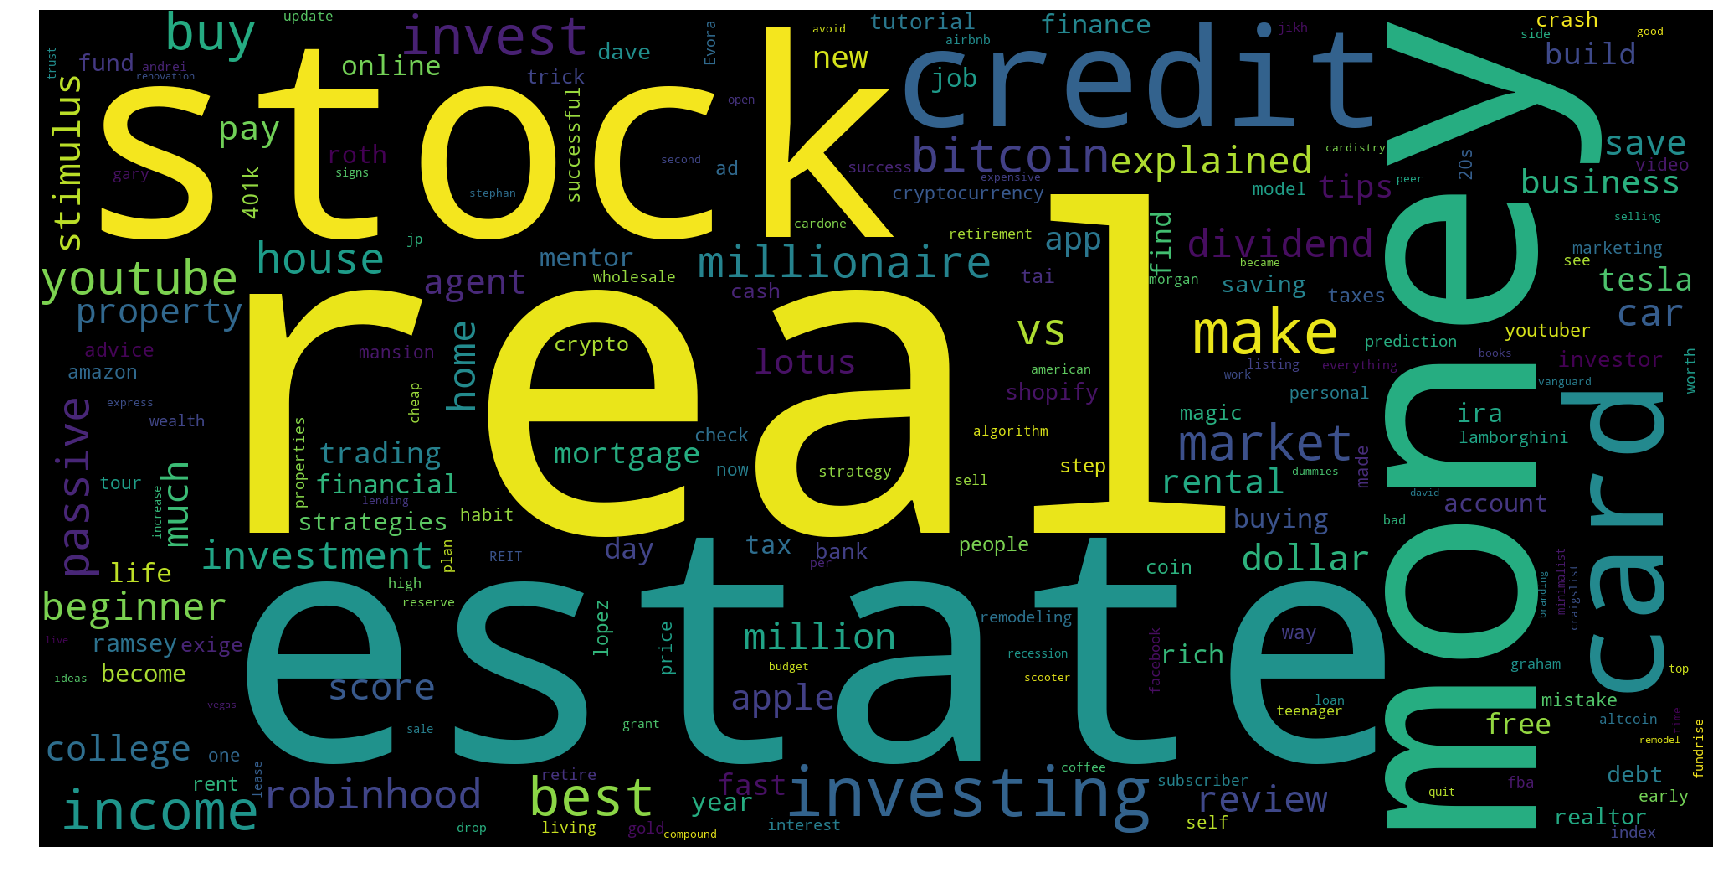

In [10]:
tags_together = ",".join([w for w in tags_list if w not in stop_words])

def plot_cloud(wordcloud):
    plt.figure(figsize=(30,20))
    plt.imshow(wordcloud)
    plt.axis("off");
    
wordcloud = WordCloud(width = 2000, height = 1000, random_state = 0, background_color = "black",
                     colormap = "viridis", collocations = False).generate(tags_together)

plot_cloud(wordcloud)

### WordCloud Titles

In [25]:
def wordclean(w):
    return re.sub(r'[^\w]', ' ', w.lower()).replace(" ", "")

In [27]:
title_list = [t.split(" ") for t in videos_df.title.values]
from_title_dict = set()
for ll in title_list:
    from_title_dict = from_title_dict.union(set(ll))
from_title_list = list(from_title_dict)
from_title_list = [wordclean(w) for w in from_title_list if w != ""]

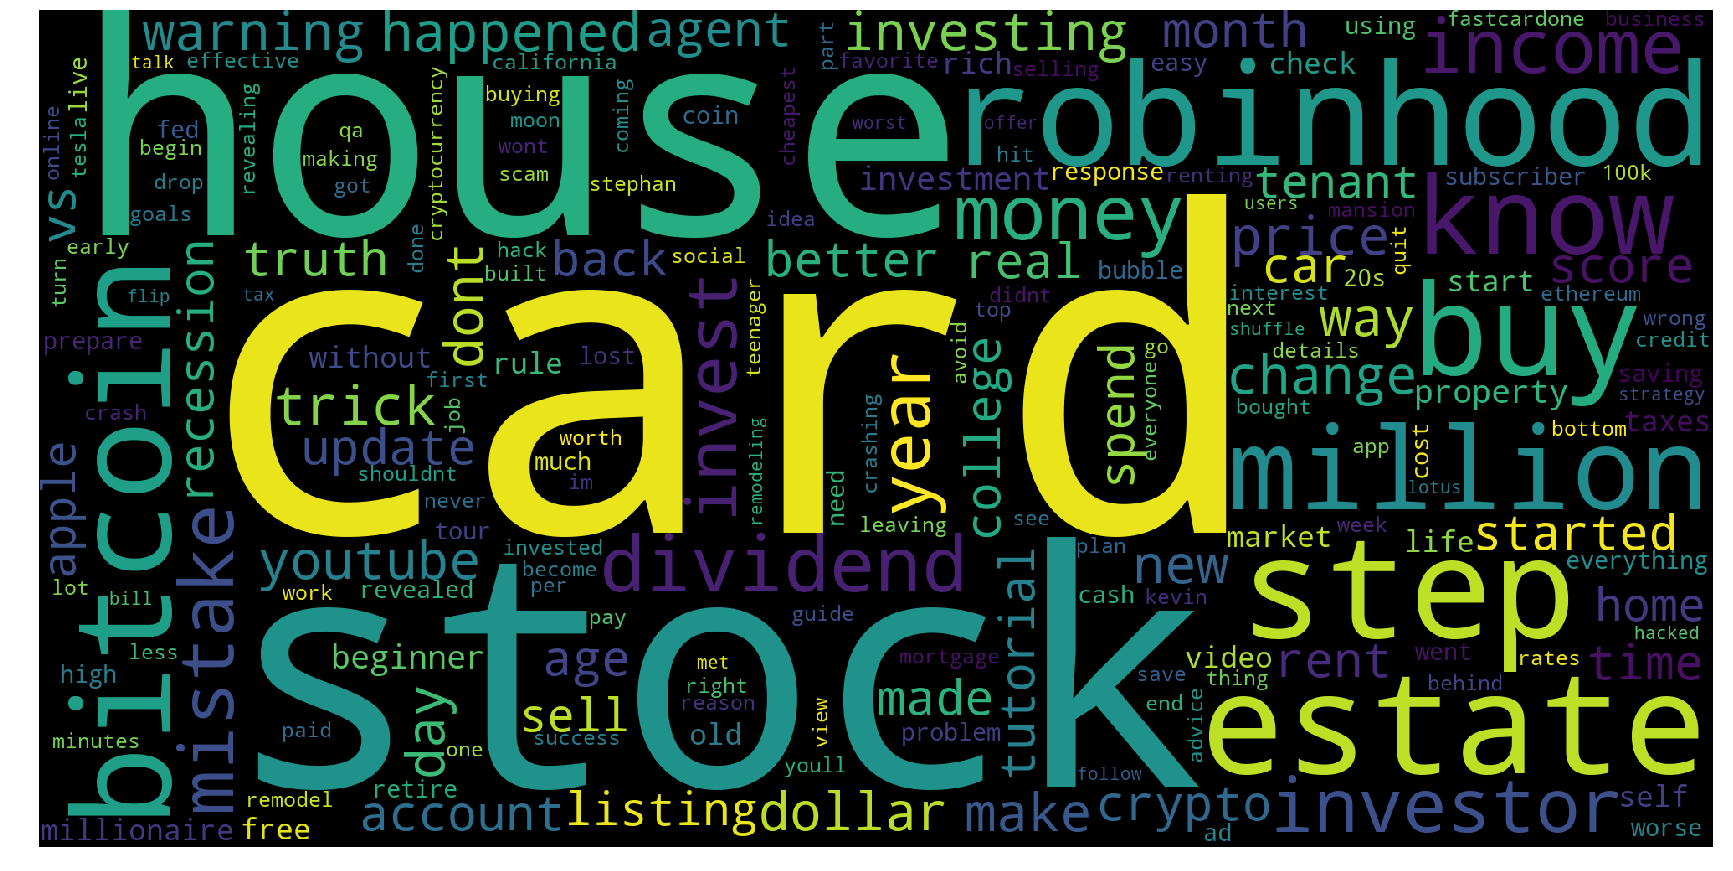

In [28]:
from_title_together = ",".join([w for w in from_title_list if w not in stop_words])
    
wordcloud = WordCloud(width = 2000, height = 1000, random_state = 0, background_color = "black",
                     colormap = "viridis", collocations = False).generate(from_title_together)

plot_cloud(wordcloud)